In [93]:
import pennylane as qml
from pennylane import numpy as np

from tqdm import tqdm
from IPython.display import clear_output

import torch
from torch.autograd import Variable
from torchvision import datasets, transforms
from functools import reduce
import random
import math
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [94]:
from pennylane import numpy as np
import matplotlib.pyplot as plt

def generate_points_distribution(data_num=2000, dist_type="circle"):
    if dist_type == 'spiral':
        theta = np.linspace(0, 5*np.pi, data_num)  # 각도 범위를 정의합니다.
        radius = np.linspace(0, 0.3, data_num)  # 반지름 범위를 정의합니다.
        xx = 0.5 + radius * np.cos(theta) + 0.012 * np.random.randn(data_num)  # x 좌표 계산
        yy = 0.5 + radius * np.sin(theta) + 0.012 * np.random.randn(data_num)  # y 좌표 계산
    
    elif dist_type == 'box':
        xx = np.random.uniform(0.3, 0.7, data_num) + 0.012 * np.random.randn(data_num)  # x 좌표 계산
        yy = np.random.uniform(0.3, 0.7, data_num) + 0.012 * np.random.randn(data_num)  # y 좌표 계산

    elif dist_type == 'curve':
        xx = np.linspace(0.15, 0.85, data_num) + 0.02 * np.random.randn(data_num)  # x 좌표 계산
        yy = 3.8 * xx*xx - 3.8 * xx + 1.2 + 0.03 * np.random.randn(data_num)  # y 좌표 계산
    
    elif dist_type == 'circle':
        radius = 0.20
        theta = np.linspace(0, 2 * np.pi, data_num)  # 각도 범위를 정의합니다.
        xx = radius * np.cos(theta) + 0.5 + 0.02 * np.random.randn(data_num)  # x 좌표 계산
        yy = radius * np.sin(theta) + 0.55 + 0.02 * np.random.randn(data_num)  # y 좌표 계산

    elif dist_type == 'lemniscate':
        xx = []
        yy = []
        while len(xx) < data_num:
            x = np.random.uniform(0, 0.5)
            y = np.random.uniform(0, 0.5)
            
            r = (x**2 + y**2)**0.5
            theta = np.arctan2(y, x)
            if r**2 <= 2 * 0.25**2 * np.cos(2 * theta):
                x = x if np.random.uniform(0, 1) < 0.5 else -x
                y = y if np.random.uniform(0, 1) < 0.5 else -y
                xx.append(x+0.5)
                yy.append(y+0.5)

    data = np.column_stack((xx, yy))  # x와 y 좌표를 합쳐서 데이터 생성
    np.random.shuffle(data)
    
    return data

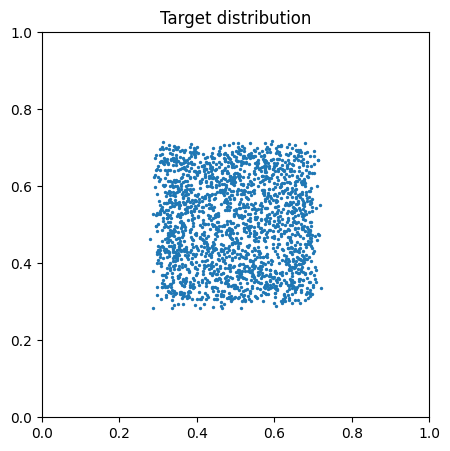

In [95]:
x = generate_points_distribution(2000, 'box')
plt.figure(figsize=(5,5))
plt.scatter(x[:,0], x[:,1], s=2.0)
plt.title('Target distribution')
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

In [96]:
# setting torch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [97]:
noise_qubits = 3
code_qubits = 2
n_qubits = noise_qubits + code_qubits
output_qubits = 2
assert(output_qubits <= noise_qubits) # 출력 큐빗은 noise qubit이하여야 한다.

n_layers = 5
BATCH_SIZE = 16
print("n_qubits = {} n_layers = {}".format(n_qubits, n_layers))

dev = qml.device("lightning.qubit", wires=n_qubits)
# dev = qml.device("ionq.simulator", wires=2)
# dev = qml.device("ionq.qpu", wires=2)

n_qubits = 5 n_layers = 5


In [98]:
coeff = 0.1

def generator_init(generator_input):
    for i in range(n_qubits):
        qml.RY(generator_input[i]*np.pi/2, wires=i) # TODO: *a 해서 값 범위 맞추기

def generator_layer(params):
    for i in range(n_qubits):
        qml.RX(params[i][0], wires=i)
        qml.RY(params[i][1], wires=i)
        qml.RZ(params[i][2], wires=i)
    
    for i in range(n_qubits):
        qml.CNOT(wires=[i, (i+1)%n_qubits])

@qml.qnode(dev, interface="torch")
def generator_circuit(params, generator_input):
    """
    quantum circuit nodeq1
    generator_input (np.array(큐빗)) : 생성기 입력 seed (noise + code)
    params (torch.Tensor(레이어,큐빗,3)): a parameter
    마지막 측정은 모두 Z로
    """

    generator_init(generator_input)

    for param in params:
        generator_layer(param)

    return [qml.probs(wires=i) for i in range(n_qubits)]

def generator_forward(params, generator_input):
    # 제너레이터 돌리고 결과 return하는 함수
    generator_output = [generator_circuit(params, single_in)[:, 0] for single_in in generator_input]
    generator_output = torch.stack(generator_output) # (BATCH_SIZE, n_qubits) 차원
    generator_output = 2 * (2 / np.pi * torch.arcsin(torch.sqrt(generator_output))) -0.5 # (BATCH_SIZE, n_qubits) 차원

    return generator_output[:, :output_qubits], generator_output[:, -code_qubits:] # noise, code 순서로 반환


def generator_train_step(params, generator_input, use_mine = False, _qmine = False):
    '''
    params (torch.Tensor(레이어,큐빗,3)): a parameter
    generator_input (torch.Tensor(BATCH_SIZE, n_qubits)): 생성기 입력 seed (noise + code). -1~1 사이의 값
    '''
    code_input = generator_input[:, -code_qubits:] # 입력중에서 code만 뽑는다. (BATCH_SIZE, code_qubits)

    generator_output, code_output = generator_forward(params, generator_input) # 출력을 뽑아낸다
    generator_output = generator_output.to(torch.float32) # (BATCH_SIZE, output_qubits)
    
    disc_output = discriminator(generator_output) # 밑에 코드에서 정의됨
    gan_loss = -torch.log(disc_output).mean()
    # print("gan_loss = ", gan_loss, gan_loss.shape)
    
    t = (code_input - code_output).pow(2).mean()

    if use_mine:
        pred_xy = mine(code_input, generator_output)
        code_input_shuffle = code_input[torch.randperm(BATCH_SIZE)]
        pred_x_y = mine(code_input_shuffle, generator_output)
        mi = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
        gan_loss -= coeff * mi

    elif _qmine:
        gan_loss += 0 # TODO: qmine loss 추가하기

    return generator_output, gan_loss# TODO: 이건 분석용으로 넣어놓음.지워야 함.

In [99]:
import torch.nn as nn
from torch.nn import functional as F

class LinearDiscriminator(nn.Module):
    def __init__(self, input_dim=output_qubits):
        super().__init__()
        self.hidden_size = 50
        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, 1),
            nn.Sigmoid())

        self.input_dim = input_dim

    def forward(self, x):
        if(len(x.shape) != 2):
            x = x.view(x.shape[0], -1)

        return self.layers(x)


class LinearMine(nn.Module):
    def __init__(self):
        super(LinearMine, self).__init__()
        H = 50
        self.fc1 = nn.Linear(code_qubits, H)
        self.fc2 = nn.Linear(output_qubits, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2

disc_loss_fn = nn.BCELoss()
def disc_cost_fn(real_input, fake_input, smoothing=False):
    batch_num = real_input.shape[0]

    disc_real = discriminator(real_input)
    disc_fake = discriminator(fake_input)

    real_label = torch.ones((batch_num, 1)).to(device)
    fake_label = torch.zeros((batch_num, 1)).to(device)
    
    if smoothing:
        real_label = real_label - 0.2*torch.rand(real_label.shape).to(device)
    
    loss = 0.5 * (disc_loss_fn(disc_real, real_label) + disc_loss_fn(disc_fake, fake_label))
    
    return loss


In [103]:
generator_params = Variable(torch.tensor(np.random.normal(-np.pi, np.pi, (n_layers, n_qubits, 3))), requires_grad=False)
discriminator = LinearDiscriminator()
mine = LinearMine()
title = 'square3_True'

In [104]:
import pickle

with open(f'result/{title}/generator_300.pkl', 'rb') as file:
    generator_params = pickle.load(file)

In [105]:
import warnings

def visualize_output(log_gen_outputs, log_gen_codes, title, rep, recorder):
    warnings.simplefilter("ignore")
    plt.figure(figsize=(10 + 4 * code_qubits, 4))  # 전체 그림의 크기 지정
    plt.subplot(1, 1 + code_qubits, 1)
    plt.title('Epoch {0}'.format(rep))
    plt.scatter(log_gen_outputs[:,0], log_gen_outputs[:,1], s=10,  alpha=0.2)
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.grid()

    for i in range(code_qubits):
        plt.subplot(1, 1 + code_qubits, 2 + i)
        plt.title('Epoch {0} code {1}'.format(rep, i))
        plt.scatter(log_gen_outputs[:,0], log_gen_outputs[:,1], s=10, c=log_gen_codes[:, i], cmap='RdYlBu', alpha=0.2)
        plt.xlim((0, 1))
        plt.ylim((0, 1))
        plt.colorbar()  # 색상 막대 추가
        plt.grid()

    plt.savefig(f'result/{title}/{rep}.png', dpi=100)
    if rep % 5 == 0:
        plt.show()
    plt.clf()
    plt.close()
    
    plt.figure(figsize=(10, 4))
    plt.title('Epoch {0} code-axis corr'.format(rep))
    plt.plot(recorder['d_loss'], label='d_loss', marker='o')
    plt.plot(recorder['g_loss'], label='g_loss', marker='o')
    plt.plot(recorder['mi'], label='mi', marker='o')
    for i in range(code_qubits):
        plt.plot(recorder[f'code{i}-x'], label=f'code{i}-x', marker='o')
        plt.plot(recorder[f'code{i}-y'], label=f'code{i}-y', marker='o')

    plt.xlabel('epoch')
    plt.ylabel('correlation')
    plt.ylim(-1, 1)
    plt.title(f'trainning graph (rep={rep})')
    plt.legend()
    plt.savefig(f'result/{title}/corr_{rep}.png', dpi=100)
    if rep % 5 == 0:
        plt.show()
    plt.clf()
    plt.close()

    plt.figure(figsize=(10, 4))
    plt.title('Epoch {0} KS stastics'.format(rep))
    plt.subplot(1, 2, 1)
    plt.plot(recorder['D_ks'], label='D_ks', marker='o')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(recorder['p-value'], label='p-value', marker='o')
    plt.yscale("log", base=10)  # 로그 스케일로 설정
    plt.legend()
    plt.savefig(f'result/{title}/ks_{rep}.png', dpi=100)
    if rep % 5 == 0:
        plt.show()
    plt.clf()
    plt.close()
    

  0%|          | 0/2000 [00:00<?, ?it/s]/opt/anaconda3/envs/pennylane/lib/python3.10/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
100%|██████████| 2000/2000 [00:06<00:00, 295.32it/s]


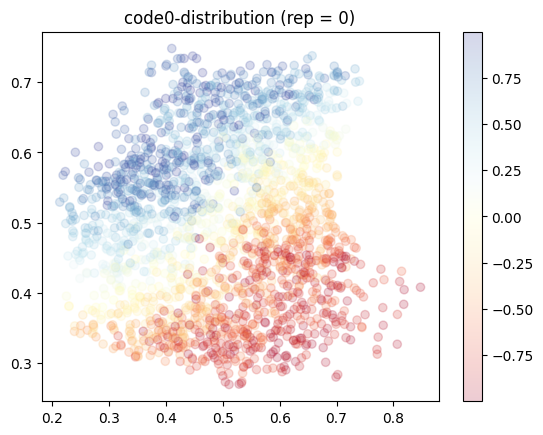

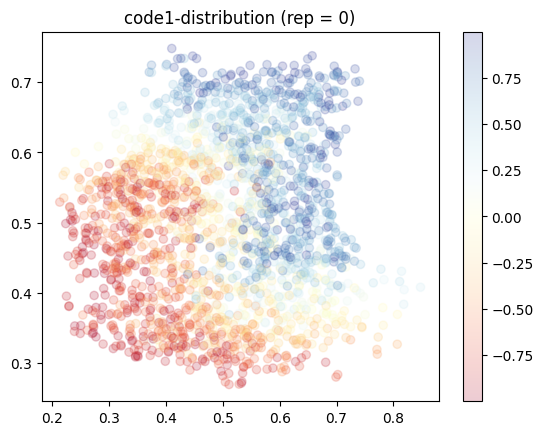

In [106]:
inputs = []
outputs = []
num = 2000
points = np.zeros((num, 3 * code_qubits))

for i in tqdm(range(2000)):
    with torch.no_grad():
        z = np.random.uniform(-1, 1, (1, n_qubits))
        code_input = z[:, -code_qubits:].reshape(code_qubits) # 입력 z중에서 code를 추출한다.
        generator_output, _ = generator_forward(generator_params, z)
        generator_output = generator_output.numpy().reshape(2)
        for j in range(code_qubits):
            points[i][j*3] = generator_output[0]
            points[i][j*3+1] = generator_output[1]
            points[i][j*3+2] = code_input[j]
        outputs.append(generator_output)
        inputs.append(code_input)

inputs = np.array(inputs).reshape(-1, code_qubits)

for code_ind in range(code_qubits):
    outputs = np.array(outputs)
    plt.scatter(outputs[:, 0], outputs[:, 1], c=inputs[:, code_ind], cmap='RdYlBu', alpha=0.2)
    plt.colorbar()  # 색상 막대 추가
    plt.title(f'code{code_ind}-distribution (rep = {final_rep})')
    plt.savefig(f'result/{title}/code_{code_ind}_{final_rep}.png')
    plt.show()

In [107]:
df = pd.DataFrame({'origin_x': x[:, 0], 'origin_y': x[:, 1]})

In [108]:
for j in range(code_qubits):
    df[f'x{j}'] = points[:, j*3]
    df[f'y{j}'] = points[:, j*3+1]
    df[f'c{j}'] = points[:, j*3+2]

In [109]:
df.to_csv(f'result/{title}/points.csv', index=False)